In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from Module.functional_ZSSSL import run_zsssl_singleecho_singlecoil
from Module.fft import ifft2c, fft2c
from Network.SSDU3D import UnrollModel
from Module.sampling import *

In [5]:
SNR = 15

In [6]:
load_path =f"data/phantom_SNR{SNR}.npy"
image = np.load(load_path)
H, W = image.shape
ksp = fft2c(image).reshape(1, H, W)

N, H, W = ksp.shape

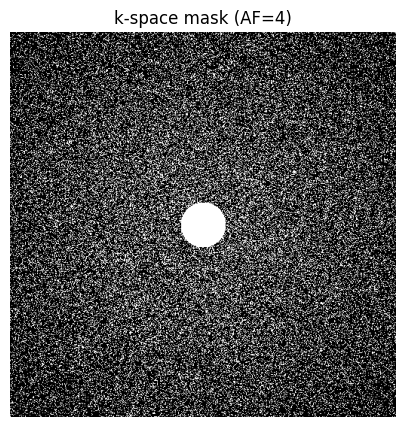

In [7]:
#mask
pattern = "gaussian"
factor = 1/4
radius = 30
std_scale = 2
seed = 100

if pattern == "gaussian":
    mask = gaussian_pattern_acs(pattern_shape=(H,W), factor=factor, radius=radius, std_scale=std_scale, seed=int(seed))
if pattern == "uniform":
    mask = uniform_pattern_acs(pattern_shape=(H,W), factor=factor, radius=radius,seed=int(seed))
mask = mask.astype(np.bool_)

save_root = os.path.join(f"result/AF{int(1/factor)}/SNR{SNR}")

plt.figure(figsize=(10, 5))
plt.title(f'k-space mask (AF={int(1/factor)})')
plt.imshow(mask, 'gray')
plt.axis('off')

plt.show()

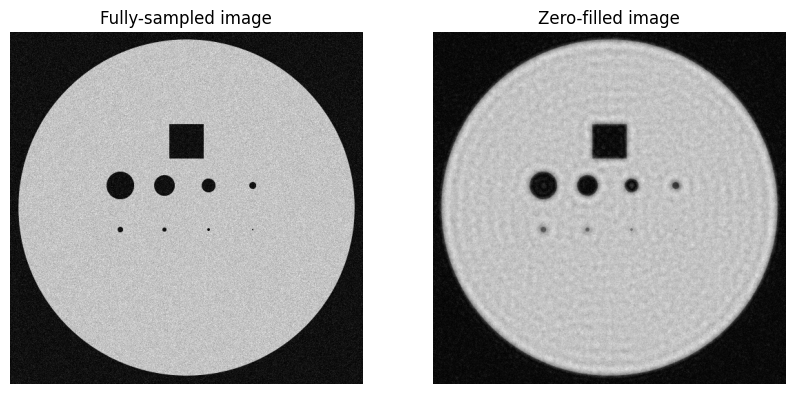

In [8]:
y_u = ksp * mask

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.title('Fully-sampled image')
plt.imshow(abs(image), 'gray', vmax=abs(image).max())
plt.axis('off')

plt.subplot(122)
plt.title('Zero-filled image')
plt.imshow(abs(ifft2c(y_u[0])), 'gray', vmax=abs(image).max())
plt.axis('off')

plt.show()

In [9]:
n_filter = 64
lr=5e-4
batch_size = 2
n_epoch = 1000
early_stop = 20

os.makedirs(save_root, exist_ok=True)

network = UnrollModel(n_filter = n_filter, n_layers = 5, k_iters = 7, with_sharing = True, n_echo = 1)
optimizer = torch.optim.Adam(network.parameters(), lr=lr)
rec_volume, network = run_zsssl_singleecho_singlecoil(
    #y_u         : fully-sampled k-space : (np.complex64) N x H x W
    #mask        : sampling mask         : (np.bool_)         H x W
    # necessary parameter
    y_u, mask, network, optimizer,
    # retrospective settings
    y = ksp, 
    # save & path_settings
    work_dir = save_root, cache_dir = "cache", store_cache = False, 
    save_npyfile = True, save_imgfile = False, cache_division = 1,
    # Zero-Shot SSL hyperparameters
    n_rep = 10, rho = 0.4, val_rho = 0.2, small_acs_block=(12, 12),
    # training settings
    device = torch.device('cuda'),
    batch_size = batch_size, n_epoch = n_epoch, early_stop = early_stop
    )

preprocessing start
Now N: 0 to 0 is processing


100%|██████████| 1/1 [00:00<00:00,  6.94it/s]


training start


1it [00:04,  4.05s/it]
1it [00:00,  3.59it/s]


1 epoch end. [Record] train_loss = 0.97, val_loss = 0.651, best_ep = 0


1it [00:00,  1.23it/s]
1it [00:00,  3.88it/s]


2 epoch end. [Stay] train_loss = 0.77, val_loss = 1.02, best_ep = 0


1it [00:00,  1.18it/s]
1it [00:00,  3.76it/s]


3 epoch end. [Stay] train_loss = 0.982, val_loss = 0.671, best_ep = 0


1it [00:00,  1.29it/s]
1it [00:00,  4.16it/s]


4 epoch end. [Record] train_loss = 0.788, val_loss = 0.649, best_ep = 3


1it [00:00,  1.29it/s]
1it [00:00,  3.50it/s]


5 epoch end. [Stay] train_loss = 0.776, val_loss = 0.675, best_ep = 3


1it [00:00,  1.33it/s]
1it [00:00,  4.27it/s]


6 epoch end. [Stay] train_loss = 0.789, val_loss = 0.689, best_ep = 3


1it [00:00,  1.25it/s]
1it [00:00,  3.93it/s]


7 epoch end. [Stay] train_loss = 0.801, val_loss = 0.691, best_ep = 3


1it [00:00,  1.34it/s]
1it [00:00,  3.73it/s]


8 epoch end. [Stay] train_loss = 0.786, val_loss = 0.683, best_ep = 3


1it [00:00,  1.27it/s]
1it [00:00,  3.69it/s]


9 epoch end. [Stay] train_loss = 0.756, val_loss = 0.664, best_ep = 3


1it [00:00,  1.44it/s]
1it [00:00,  4.19it/s]


10 epoch end. [Record] train_loss = 0.767, val_loss = 0.636, best_ep = 9


1it [00:00,  1.43it/s]
1it [00:00,  4.43it/s]


11 epoch end. [Record] train_loss = 0.757, val_loss = 0.618, best_ep = 10


1it [00:00,  1.44it/s]
1it [00:00,  4.33it/s]


12 epoch end. [Record] train_loss = 0.712, val_loss = 0.573, best_ep = 11


1it [00:00,  1.43it/s]
1it [00:00,  4.48it/s]


13 epoch end. [Record] train_loss = 0.719, val_loss = 0.561, best_ep = 12


1it [00:00,  1.40it/s]
1it [00:00,  4.42it/s]


14 epoch end. [Stay] train_loss = 0.669, val_loss = 0.574, best_ep = 12


1it [00:00,  1.32it/s]
1it [00:00,  4.43it/s]


15 epoch end. [Record] train_loss = 0.686, val_loss = 0.539, best_ep = 14


1it [00:00,  1.43it/s]
1it [00:00,  4.15it/s]


16 epoch end. [Stay] train_loss = 0.702, val_loss = 0.54, best_ep = 14


1it [00:00,  1.38it/s]
1it [00:00,  4.19it/s]


17 epoch end. [Stay] train_loss = 0.648, val_loss = 0.553, best_ep = 14


1it [00:00,  1.40it/s]
1it [00:00,  4.06it/s]


18 epoch end. [Stay] train_loss = 0.685, val_loss = 0.557, best_ep = 14


1it [00:00,  1.39it/s]
1it [00:00,  3.80it/s]


19 epoch end. [Stay] train_loss = 0.659, val_loss = 0.549, best_ep = 14


1it [00:00,  1.35it/s]
1it [00:00,  4.58it/s]


20 epoch end. [Record] train_loss = 0.675, val_loss = 0.534, best_ep = 19


1it [00:00,  1.40it/s]
1it [00:00,  3.85it/s]


21 epoch end. [Record] train_loss = 0.65, val_loss = 0.528, best_ep = 20


1it [00:00,  1.26it/s]
1it [00:00,  4.36it/s]


22 epoch end. [Stay] train_loss = 0.654, val_loss = 0.541, best_ep = 20


1it [00:00,  1.32it/s]
1it [00:00,  3.61it/s]


23 epoch end. [Stay] train_loss = 0.7, val_loss = 0.545, best_ep = 20


1it [00:00,  1.42it/s]
1it [00:00,  3.51it/s]


24 epoch end. [Stay] train_loss = 0.682, val_loss = 0.534, best_ep = 20


1it [00:00,  1.39it/s]
1it [00:00,  3.87it/s]


25 epoch end. [Stay] train_loss = 0.656, val_loss = 0.53, best_ep = 20


1it [00:00,  1.41it/s]
1it [00:00,  3.93it/s]


26 epoch end. [Stay] train_loss = 0.663, val_loss = 0.53, best_ep = 20


1it [00:00,  1.44it/s]
1it [00:00,  4.29it/s]


27 epoch end. [Record] train_loss = 0.646, val_loss = 0.528, best_ep = 26


1it [00:00,  1.42it/s]
1it [00:00,  4.49it/s]


28 epoch end. [Record] train_loss = 0.633, val_loss = 0.522, best_ep = 27


1it [00:00,  1.42it/s]
1it [00:00,  4.23it/s]


29 epoch end. [Record] train_loss = 0.675, val_loss = 0.52, best_ep = 28


1it [00:00,  1.38it/s]
1it [00:00,  3.88it/s]


30 epoch end. [Stay] train_loss = 0.649, val_loss = 0.526, best_ep = 28


1it [00:00,  1.32it/s]
1it [00:00,  3.65it/s]


31 epoch end. [Stay] train_loss = 0.683, val_loss = 0.528, best_ep = 28


1it [00:00,  1.34it/s]
1it [00:00,  4.44it/s]


32 epoch end. [Stay] train_loss = 0.686, val_loss = 0.521, best_ep = 28


1it [00:00,  1.42it/s]
1it [00:00,  3.89it/s]


33 epoch end. [Record] train_loss = 0.627, val_loss = 0.519, best_ep = 32


1it [00:00,  1.46it/s]
1it [00:00,  4.52it/s]


34 epoch end. [Stay] train_loss = 0.623, val_loss = 0.522, best_ep = 32


1it [00:00,  1.40it/s]
1it [00:00,  4.32it/s]


35 epoch end. [Stay] train_loss = 0.652, val_loss = 0.52, best_ep = 32


1it [00:00,  1.40it/s]
1it [00:00,  4.60it/s]


36 epoch end. [Record] train_loss = 0.652, val_loss = 0.517, best_ep = 35


1it [00:00,  1.37it/s]
1it [00:00,  4.20it/s]


37 epoch end. [Stay] train_loss = 0.646, val_loss = 0.519, best_ep = 35


1it [00:00,  1.41it/s]
1it [00:00,  4.24it/s]


38 epoch end. [Stay] train_loss = 0.651, val_loss = 0.521, best_ep = 35


1it [00:00,  1.39it/s]
1it [00:00,  4.21it/s]


39 epoch end. [Record] train_loss = 0.624, val_loss = 0.514, best_ep = 38


1it [00:00,  1.37it/s]
1it [00:00,  3.90it/s]


40 epoch end. [Record] train_loss = 0.616, val_loss = 0.512, best_ep = 39


1it [00:00,  1.41it/s]
1it [00:00,  4.24it/s]


41 epoch end. [Stay] train_loss = 0.661, val_loss = 0.517, best_ep = 39


1it [00:00,  1.34it/s]
1it [00:00,  3.86it/s]


42 epoch end. [Stay] train_loss = 0.632, val_loss = 0.517, best_ep = 39


1it [00:00,  1.36it/s]
1it [00:00,  4.17it/s]


43 epoch end. [Record] train_loss = 0.624, val_loss = 0.511, best_ep = 42


1it [00:00,  1.41it/s]
1it [00:00,  4.39it/s]


44 epoch end. [Record] train_loss = 0.673, val_loss = 0.51, best_ep = 43


1it [00:00,  1.41it/s]
1it [00:00,  3.44it/s]


45 epoch end. [Stay] train_loss = 0.614, val_loss = 0.514, best_ep = 43


1it [00:00,  1.41it/s]
1it [00:00,  3.94it/s]


46 epoch end. [Stay] train_loss = 0.675, val_loss = 0.511, best_ep = 43


1it [00:00,  1.43it/s]
1it [00:00,  4.34it/s]


47 epoch end. [Record] train_loss = 0.631, val_loss = 0.508, best_ep = 46


1it [00:00,  1.40it/s]
1it [00:00,  4.21it/s]


48 epoch end. [Stay] train_loss = 0.61, val_loss = 0.512, best_ep = 46


1it [00:00,  1.38it/s]
1it [00:00,  4.23it/s]


49 epoch end. [Stay] train_loss = 0.644, val_loss = 0.509, best_ep = 46


1it [00:00,  1.43it/s]
1it [00:00,  4.44it/s]


50 epoch end. [Record] train_loss = 0.613, val_loss = 0.504, best_ep = 49


1it [00:00,  1.41it/s]
1it [00:00,  4.40it/s]


51 epoch end. [Stay] train_loss = 0.655, val_loss = 0.511, best_ep = 49


1it [00:00,  1.43it/s]
1it [00:00,  4.30it/s]


52 epoch end. [Stay] train_loss = 0.657, val_loss = 0.511, best_ep = 49


1it [00:00,  1.41it/s]
1it [00:00,  4.27it/s]


53 epoch end. [Record] train_loss = 0.609, val_loss = 0.503, best_ep = 52


1it [00:00,  1.44it/s]
1it [00:00,  4.47it/s]


54 epoch end. [Record] train_loss = 0.603, val_loss = 0.499, best_ep = 53


1it [00:00,  1.44it/s]
1it [00:00,  4.40it/s]


55 epoch end. [Record] train_loss = 0.649, val_loss = 0.499, best_ep = 54


1it [00:00,  1.44it/s]
1it [00:00,  4.51it/s]


56 epoch end. [Record] train_loss = 0.599, val_loss = 0.498, best_ep = 55


1it [00:00,  1.36it/s]
1it [00:00,  4.46it/s]


57 epoch end. [Stay] train_loss = 0.627, val_loss = 0.499, best_ep = 55


1it [00:00,  1.43it/s]
1it [00:00,  3.58it/s]


58 epoch end. [Stay] train_loss = 0.593, val_loss = 0.499, best_ep = 55


1it [00:00,  1.36it/s]
1it [00:00,  4.45it/s]


59 epoch end. [Record] train_loss = 0.592, val_loss = 0.497, best_ep = 58


1it [00:00,  1.34it/s]
1it [00:00,  4.37it/s]


60 epoch end. [Record] train_loss = 0.619, val_loss = 0.496, best_ep = 59


1it [00:00,  1.43it/s]
1it [00:00,  4.44it/s]


61 epoch end. [Record] train_loss = 0.606, val_loss = 0.494, best_ep = 60


1it [00:00,  1.43it/s]
1it [00:00,  4.08it/s]


62 epoch end. [Record] train_loss = 0.646, val_loss = 0.494, best_ep = 61


1it [00:00,  1.37it/s]
1it [00:00,  4.33it/s]


63 epoch end. [Record] train_loss = 0.584, val_loss = 0.494, best_ep = 62


1it [00:00,  1.40it/s]
1it [00:00,  3.94it/s]


64 epoch end. [Stay] train_loss = 0.641, val_loss = 0.495, best_ep = 62


1it [00:00,  1.30it/s]
1it [00:00,  4.23it/s]


65 epoch end. [Stay] train_loss = 0.627, val_loss = 0.495, best_ep = 62


1it [00:00,  1.33it/s]
1it [00:00,  3.53it/s]


66 epoch end. [Record] train_loss = 0.608, val_loss = 0.492, best_ep = 65


1it [00:00,  1.42it/s]
1it [00:00,  3.88it/s]


67 epoch end. [Record] train_loss = 0.575, val_loss = 0.487, best_ep = 66


1it [00:00,  1.38it/s]
1it [00:00,  4.34it/s]


68 epoch end. [Record] train_loss = 0.591, val_loss = 0.484, best_ep = 67


1it [00:00,  1.41it/s]
1it [00:00,  3.58it/s]


69 epoch end. [Record] train_loss = 0.571, val_loss = 0.483, best_ep = 68


1it [00:00,  1.34it/s]
1it [00:00,  3.63it/s]


70 epoch end. [Stay] train_loss = 0.566, val_loss = 0.487, best_ep = 68


1it [00:00,  1.33it/s]
1it [00:00,  4.25it/s]


71 epoch end. [Stay] train_loss = 0.611, val_loss = 0.487, best_ep = 68


1it [00:00,  1.39it/s]
1it [00:00,  3.89it/s]


72 epoch end. [Record] train_loss = 0.584, val_loss = 0.479, best_ep = 71


1it [00:00,  1.38it/s]
1it [00:00,  4.40it/s]


73 epoch end. [Record] train_loss = 0.558, val_loss = 0.477, best_ep = 72


1it [00:00,  1.35it/s]
1it [00:00,  3.38it/s]


74 epoch end. [Stay] train_loss = 0.606, val_loss = 0.479, best_ep = 72


1it [00:00,  1.39it/s]
1it [00:00,  4.56it/s]


75 epoch end. [Stay] train_loss = 0.566, val_loss = 0.486, best_ep = 72


1it [00:00,  1.43it/s]
1it [00:00,  4.33it/s]


76 epoch end. [Stay] train_loss = 0.575, val_loss = 0.48, best_ep = 72


1it [00:00,  1.21it/s]
1it [00:00,  4.28it/s]


77 epoch end. [Record] train_loss = 0.558, val_loss = 0.475, best_ep = 76


1it [00:00,  1.43it/s]
1it [00:00,  4.43it/s]


78 epoch end. [Record] train_loss = 0.604, val_loss = 0.475, best_ep = 77


1it [00:00,  1.43it/s]
1it [00:00,  4.47it/s]


79 epoch end. [Stay] train_loss = 0.574, val_loss = 0.479, best_ep = 77


1it [00:00,  1.43it/s]
1it [00:00,  4.33it/s]


80 epoch end. [Stay] train_loss = 0.54, val_loss = 0.476, best_ep = 77


1it [00:00,  1.41it/s]
1it [00:00,  4.50it/s]


81 epoch end. [Record] train_loss = 0.537, val_loss = 0.471, best_ep = 80


1it [00:00,  1.40it/s]
1it [00:00,  4.09it/s]


82 epoch end. [Record] train_loss = 0.543, val_loss = 0.47, best_ep = 81


1it [00:00,  1.41it/s]
1it [00:00,  4.34it/s]


83 epoch end. [Stay] train_loss = 0.549, val_loss = 0.47, best_ep = 81


1it [00:00,  1.40it/s]
1it [00:00,  4.29it/s]


84 epoch end. [Stay] train_loss = 0.545, val_loss = 0.47, best_ep = 81


1it [00:00,  1.40it/s]
1it [00:00,  3.58it/s]


85 epoch end. [Record] train_loss = 0.523, val_loss = 0.468, best_ep = 84


1it [00:00,  1.41it/s]
1it [00:00,  3.41it/s]


86 epoch end. [Record] train_loss = 0.519, val_loss = 0.466, best_ep = 85


1it [00:00,  1.37it/s]
1it [00:00,  3.31it/s]


87 epoch end. [Stay] train_loss = 0.539, val_loss = 0.468, best_ep = 85


1it [00:00,  1.40it/s]
1it [00:00,  4.01it/s]


88 epoch end. [Stay] train_loss = 0.534, val_loss = 0.469, best_ep = 85


1it [00:00,  1.33it/s]
1it [00:00,  4.30it/s]


89 epoch end. [Record] train_loss = 0.544, val_loss = 0.465, best_ep = 88


1it [00:00,  1.43it/s]
1it [00:00,  3.61it/s]


90 epoch end. [Record] train_loss = 0.539, val_loss = 0.462, best_ep = 89


1it [00:00,  1.33it/s]
1it [00:00,  3.97it/s]


91 epoch end. [Record] train_loss = 0.503, val_loss = 0.459, best_ep = 90


1it [00:00,  1.42it/s]
1it [00:00,  3.14it/s]


92 epoch end. [Stay] train_loss = 0.539, val_loss = 0.468, best_ep = 90


1it [00:00,  1.32it/s]
1it [00:00,  4.22it/s]


93 epoch end. [Stay] train_loss = 0.527, val_loss = 0.461, best_ep = 90


1it [00:00,  1.37it/s]
1it [00:00,  4.51it/s]


94 epoch end. [Record] train_loss = 0.493, val_loss = 0.456, best_ep = 93


1it [00:00,  1.37it/s]
1it [00:00,  3.72it/s]


95 epoch end. [Stay] train_loss = 0.494, val_loss = 0.458, best_ep = 93


1it [00:00,  1.40it/s]
1it [00:00,  4.24it/s]


96 epoch end. [Stay] train_loss = 0.497, val_loss = 0.467, best_ep = 93


1it [00:00,  1.34it/s]
1it [00:00,  4.57it/s]


97 epoch end. [Stay] train_loss = 0.519, val_loss = 0.462, best_ep = 93


1it [00:00,  1.44it/s]
1it [00:00,  4.67it/s]


98 epoch end. [Record] train_loss = 0.479, val_loss = 0.455, best_ep = 97


1it [00:00,  1.43it/s]
1it [00:00,  4.04it/s]


99 epoch end. [Stay] train_loss = 0.491, val_loss = 0.463, best_ep = 97


1it [00:00,  1.38it/s]
1it [00:00,  4.46it/s]


100 epoch end. [Stay] train_loss = 0.479, val_loss = 0.465, best_ep = 97


1it [00:00,  1.42it/s]
1it [00:00,  4.46it/s]


101 epoch end. [Stay] train_loss = 0.504, val_loss = 0.462, best_ep = 97


1it [00:00,  1.37it/s]
1it [00:00,  3.44it/s]


102 epoch end. [Stay] train_loss = 0.501, val_loss = 0.46, best_ep = 97


1it [00:00,  1.36it/s]
1it [00:00,  3.72it/s]


103 epoch end. [Stay] train_loss = 0.481, val_loss = 0.456, best_ep = 97


1it [00:00,  1.29it/s]
1it [00:00,  2.81it/s]


104 epoch end. [Stay] train_loss = 0.5, val_loss = 0.487, best_ep = 97


1it [00:00,  1.36it/s]
1it [00:00,  4.02it/s]


105 epoch end. [Stay] train_loss = 0.497, val_loss = 0.463, best_ep = 97


1it [00:00,  1.40it/s]
1it [00:00,  4.31it/s]


106 epoch end. [Stay] train_loss = 0.481, val_loss = 0.457, best_ep = 97


1it [00:00,  1.40it/s]
1it [00:00,  4.32it/s]


107 epoch end. [Stay] train_loss = 0.476, val_loss = 0.473, best_ep = 97


1it [00:00,  1.43it/s]
1it [00:00,  4.42it/s]


108 epoch end. [Stay] train_loss = 0.498, val_loss = 0.463, best_ep = 97


1it [00:00,  1.42it/s]
1it [00:00,  4.12it/s]


109 epoch end. [Stay] train_loss = 0.501, val_loss = 0.456, best_ep = 97


1it [00:00,  1.41it/s]
1it [00:00,  4.51it/s]


110 epoch end. [Stay] train_loss = 0.504, val_loss = 0.46, best_ep = 97


1it [00:00,  1.32it/s]
1it [00:00,  4.23it/s]


111 epoch end. [Stay] train_loss = 0.485, val_loss = 0.469, best_ep = 97


1it [00:00,  1.39it/s]
1it [00:00,  4.01it/s]


112 epoch end. [Stay] train_loss = 0.482, val_loss = 0.457, best_ep = 97


1it [00:00,  1.41it/s]
1it [00:00,  4.49it/s]


113 epoch end. [Stay] train_loss = 0.496, val_loss = 0.457, best_ep = 97


1it [00:00,  1.43it/s]
1it [00:00,  4.32it/s]


114 epoch end. [Stay] train_loss = 0.496, val_loss = 0.471, best_ep = 97


1it [00:00,  1.33it/s]
1it [00:00,  3.97it/s]


115 epoch end. [Stay] train_loss = 0.484, val_loss = 0.457, best_ep = 97


1it [00:00,  1.36it/s]
1it [00:00,  3.82it/s]


116 epoch end. [Record] train_loss = 0.493, val_loss = 0.454, best_ep = 115


1it [00:00,  1.35it/s]
1it [00:00,  4.25it/s]


117 epoch end. [Stay] train_loss = 0.463, val_loss = 0.46, best_ep = 115


1it [00:00,  1.37it/s]
1it [00:00,  4.03it/s]


118 epoch end. [Stay] train_loss = 0.464, val_loss = 0.457, best_ep = 115


1it [00:00,  1.42it/s]
1it [00:00,  4.08it/s]


119 epoch end. [Record] train_loss = 0.467, val_loss = 0.453, best_ep = 118


1it [00:00,  1.35it/s]
1it [00:00,  4.38it/s]


120 epoch end. [Stay] train_loss = 0.471, val_loss = 0.454, best_ep = 118


1it [00:00,  1.39it/s]
1it [00:00,  4.31it/s]


121 epoch end. [Stay] train_loss = 0.468, val_loss = 0.459, best_ep = 118


1it [00:00,  1.35it/s]
1it [00:00,  4.54it/s]


122 epoch end. [Stay] train_loss = 0.461, val_loss = 0.455, best_ep = 118


1it [00:00,  1.45it/s]
1it [00:00,  4.33it/s]


123 epoch end. [Stay] train_loss = 0.458, val_loss = 0.454, best_ep = 118


1it [00:00,  1.30it/s]
1it [00:00,  4.27it/s]


124 epoch end. [Stay] train_loss = 0.46, val_loss = 0.457, best_ep = 118


1it [00:00,  1.40it/s]
1it [00:00,  3.87it/s]


125 epoch end. [Stay] train_loss = 0.461, val_loss = 0.456, best_ep = 118


1it [00:00,  1.37it/s]
1it [00:00,  3.45it/s]


126 epoch end. [Stay] train_loss = 0.479, val_loss = 0.461, best_ep = 118


1it [00:00,  1.41it/s]
1it [00:00,  4.17it/s]


127 epoch end. [Stay] train_loss = 0.482, val_loss = 0.458, best_ep = 118


1it [00:00,  1.39it/s]
1it [00:00,  3.71it/s]


128 epoch end. [Stay] train_loss = 0.473, val_loss = 0.455, best_ep = 118


1it [00:00,  1.37it/s]
1it [00:00,  3.66it/s]


129 epoch end. [Stay] train_loss = 0.461, val_loss = 0.454, best_ep = 118


1it [00:00,  1.38it/s]
1it [00:00,  4.33it/s]


130 epoch end. [Stay] train_loss = 0.483, val_loss = 0.462, best_ep = 118


1it [00:00,  1.34it/s]
1it [00:00,  4.07it/s]


131 epoch end. [Stay] train_loss = 0.467, val_loss = 0.454, best_ep = 118


1it [00:00,  1.39it/s]
1it [00:00,  3.84it/s]


132 epoch end. [Stay] train_loss = 0.476, val_loss = 0.454, best_ep = 118


1it [00:00,  1.38it/s]
1it [00:00,  3.95it/s]


133 epoch end. [Record] train_loss = 0.457, val_loss = 0.451, best_ep = 132


1it [00:00,  1.39it/s]
1it [00:00,  3.95it/s]


134 epoch end. [Stay] train_loss = 0.458, val_loss = 0.451, best_ep = 132


1it [00:00,  1.36it/s]
1it [00:00,  3.70it/s]


135 epoch end. [Record] train_loss = 0.462, val_loss = 0.45, best_ep = 134


1it [00:00,  1.40it/s]
1it [00:00,  4.13it/s]


136 epoch end. [Stay] train_loss = 0.474, val_loss = 0.463, best_ep = 134


1it [00:00,  1.37it/s]
1it [00:00,  2.57it/s]


137 epoch end. [Stay] train_loss = 0.468, val_loss = 0.451, best_ep = 134


1it [00:00,  1.28it/s]
1it [00:00,  4.44it/s]


138 epoch end. [Record] train_loss = 0.457, val_loss = 0.45, best_ep = 137


1it [00:00,  1.37it/s]
1it [00:00,  4.23it/s]


139 epoch end. [Stay] train_loss = 0.453, val_loss = 0.459, best_ep = 137


1it [00:00,  1.35it/s]
1it [00:00,  4.11it/s]


140 epoch end. [Stay] train_loss = 0.458, val_loss = 0.45, best_ep = 137


1it [00:00,  1.35it/s]
1it [00:00,  4.34it/s]


141 epoch end. [Record] train_loss = 0.458, val_loss = 0.448, best_ep = 140


1it [00:00,  1.42it/s]
1it [00:00,  4.15it/s]


142 epoch end. [Stay] train_loss = 0.454, val_loss = 0.455, best_ep = 140


1it [00:00,  1.41it/s]
1it [00:00,  4.00it/s]


143 epoch end. [Stay] train_loss = 0.459, val_loss = 0.45, best_ep = 140


1it [00:00,  1.41it/s]
1it [00:00,  4.53it/s]


144 epoch end. [Stay] train_loss = 0.464, val_loss = 0.448, best_ep = 140


1it [00:00,  1.40it/s]
1it [00:00,  4.58it/s]


145 epoch end. [Stay] train_loss = 0.446, val_loss = 0.449, best_ep = 140


1it [00:00,  1.36it/s]
1it [00:00,  3.96it/s]


146 epoch end. [Stay] train_loss = 0.469, val_loss = 0.46, best_ep = 140


1it [00:00,  1.37it/s]
1it [00:00,  4.35it/s]


147 epoch end. [Stay] train_loss = 0.456, val_loss = 0.449, best_ep = 140


1it [00:00,  1.37it/s]
1it [00:00,  3.99it/s]


148 epoch end. [Stay] train_loss = 0.466, val_loss = 0.451, best_ep = 140


1it [00:00,  1.36it/s]
1it [00:00,  4.29it/s]


149 epoch end. [Stay] train_loss = 0.449, val_loss = 0.449, best_ep = 140


1it [00:00,  1.36it/s]
1it [00:00,  3.60it/s]


150 epoch end. [Stay] train_loss = 0.461, val_loss = 0.454, best_ep = 140


1it [00:00,  1.34it/s]
1it [00:00,  4.48it/s]


151 epoch end. [Stay] train_loss = 0.447, val_loss = 0.448, best_ep = 140


1it [00:00,  1.35it/s]
1it [00:00,  4.17it/s]


152 epoch end. [Stay] train_loss = 0.451, val_loss = 0.449, best_ep = 140


1it [00:00,  1.41it/s]
1it [00:00,  4.40it/s]


153 epoch end. [Stay] train_loss = 0.447, val_loss = 0.453, best_ep = 140


1it [00:00,  1.41it/s]
1it [00:00,  3.55it/s]


154 epoch end. [Stay] train_loss = 0.463, val_loss = 0.452, best_ep = 140


1it [00:00,  1.37it/s]
1it [00:00,  4.34it/s]


155 epoch end. [Stay] train_loss = 0.443, val_loss = 0.449, best_ep = 140


1it [00:00,  1.34it/s]
1it [00:00,  4.33it/s]


156 epoch end. [Stay] train_loss = 0.468, val_loss = 0.459, best_ep = 140


1it [00:00,  1.38it/s]
1it [00:00,  4.40it/s]


157 epoch end. [Record] train_loss = 0.455, val_loss = 0.448, best_ep = 156


1it [00:00,  1.34it/s]
1it [00:00,  4.10it/s]


158 epoch end. [Stay] train_loss = 0.444, val_loss = 0.448, best_ep = 156


1it [00:00,  1.30it/s]
1it [00:00,  4.02it/s]


159 epoch end. [Stay] train_loss = 0.451, val_loss = 0.452, best_ep = 156


1it [00:00,  1.38it/s]
1it [00:00,  3.88it/s]


160 epoch end. [Stay] train_loss = 0.454, val_loss = 0.448, best_ep = 156


1it [00:00,  1.35it/s]
1it [00:00,  3.40it/s]


161 epoch end. [Record] train_loss = 0.455, val_loss = 0.446, best_ep = 160


1it [00:00,  1.34it/s]
1it [00:00,  3.83it/s]


162 epoch end. [Record] train_loss = 0.443, val_loss = 0.446, best_ep = 161


1it [00:00,  1.32it/s]
1it [00:00,  4.34it/s]


163 epoch end. [Stay] train_loss = 0.449, val_loss = 0.446, best_ep = 161


1it [00:00,  1.38it/s]
1it [00:00,  4.47it/s]


164 epoch end. [Stay] train_loss = 0.444, val_loss = 0.446, best_ep = 161


1it [00:00,  1.41it/s]
1it [00:00,  4.40it/s]


165 epoch end. [Stay] train_loss = 0.453, val_loss = 0.453, best_ep = 161


1it [00:00,  1.38it/s]
1it [00:00,  4.21it/s]


166 epoch end. [Record] train_loss = 0.454, val_loss = 0.445, best_ep = 165


1it [00:00,  1.41it/s]
1it [00:00,  4.55it/s]


167 epoch end. [Record] train_loss = 0.448, val_loss = 0.445, best_ep = 166


1it [00:00,  1.41it/s]
1it [00:00,  4.02it/s]


168 epoch end. [Stay] train_loss = 0.454, val_loss = 0.465, best_ep = 166


1it [00:00,  1.38it/s]
1it [00:00,  3.24it/s]


169 epoch end. [Stay] train_loss = 0.455, val_loss = 0.446, best_ep = 166


1it [00:00,  1.37it/s]
1it [00:00,  3.58it/s]


170 epoch end. [Stay] train_loss = 0.441, val_loss = 0.445, best_ep = 166


1it [00:00,  1.34it/s]
1it [00:00,  4.33it/s]


171 epoch end. [Stay] train_loss = 0.459, val_loss = 0.471, best_ep = 166


1it [00:00,  1.40it/s]
1it [00:00,  3.36it/s]


172 epoch end. [Stay] train_loss = 0.469, val_loss = 0.446, best_ep = 166


1it [00:00,  1.33it/s]
1it [00:00,  3.56it/s]


173 epoch end. [Stay] train_loss = 0.446, val_loss = 0.452, best_ep = 166


1it [00:00,  1.37it/s]
1it [00:00,  4.15it/s]


174 epoch end. [Stay] train_loss = 0.455, val_loss = 0.453, best_ep = 166


1it [00:00,  1.38it/s]
1it [00:00,  4.24it/s]


175 epoch end. [Stay] train_loss = 0.44, val_loss = 0.456, best_ep = 166


1it [00:00,  1.38it/s]
1it [00:00,  3.53it/s]


176 epoch end. [Record] train_loss = 0.454, val_loss = 0.444, best_ep = 175


1it [00:00,  1.33it/s]
1it [00:00,  3.52it/s]


177 epoch end. [Stay] train_loss = 0.437, val_loss = 0.444, best_ep = 175


1it [00:00,  1.33it/s]
1it [00:00,  4.37it/s]


178 epoch end. [Stay] train_loss = 0.44, val_loss = 0.451, best_ep = 175


1it [00:00,  1.35it/s]
1it [00:00,  4.46it/s]


179 epoch end. [Stay] train_loss = 0.451, val_loss = 0.451, best_ep = 175


1it [00:00,  1.38it/s]
1it [00:00,  4.04it/s]


180 epoch end. [Stay] train_loss = 0.448, val_loss = 0.446, best_ep = 175


1it [00:00,  1.36it/s]
1it [00:00,  4.11it/s]


181 epoch end. [Record] train_loss = 0.451, val_loss = 0.444, best_ep = 180


1it [00:00,  1.34it/s]
1it [00:00,  3.65it/s]


182 epoch end. [Stay] train_loss = 0.452, val_loss = 0.47, best_ep = 180


1it [00:00,  1.39it/s]
1it [00:00,  3.83it/s]


183 epoch end. [Stay] train_loss = 0.46, val_loss = 0.445, best_ep = 180


1it [00:00,  1.39it/s]
1it [00:00,  4.20it/s]


184 epoch end. [Stay] train_loss = 0.441, val_loss = 0.45, best_ep = 180


1it [00:00,  1.42it/s]
1it [00:00,  4.46it/s]


185 epoch end. [Stay] train_loss = 0.472, val_loss = 0.451, best_ep = 180


1it [00:00,  1.34it/s]
1it [00:00,  4.35it/s]


186 epoch end. [Stay] train_loss = 0.452, val_loss = 0.472, best_ep = 180


1it [00:00,  1.40it/s]
1it [00:00,  3.82it/s]


187 epoch end. [Record] train_loss = 0.469, val_loss = 0.444, best_ep = 186


1it [00:00,  1.40it/s]
1it [00:00,  4.36it/s]


188 epoch end. [Stay] train_loss = 0.457, val_loss = 0.446, best_ep = 186


1it [00:00,  1.33it/s]
1it [00:00,  3.52it/s]


189 epoch end. [Stay] train_loss = 0.441, val_loss = 0.452, best_ep = 186


1it [00:00,  1.40it/s]
1it [00:00,  4.04it/s]


190 epoch end. [Stay] train_loss = 0.448, val_loss = 0.449, best_ep = 186


1it [00:00,  1.33it/s]
1it [00:00,  4.37it/s]


191 epoch end. [Stay] train_loss = 0.451, val_loss = 0.445, best_ep = 186


1it [00:00,  1.34it/s]
1it [00:00,  4.25it/s]


192 epoch end. [Stay] train_loss = 0.446, val_loss = 0.444, best_ep = 186


1it [00:00,  1.41it/s]
1it [00:00,  4.51it/s]


193 epoch end. [Stay] train_loss = 0.451, val_loss = 0.451, best_ep = 186


1it [00:00,  1.39it/s]
1it [00:00,  4.12it/s]


194 epoch end. [Stay] train_loss = 0.44, val_loss = 0.446, best_ep = 186


1it [00:00,  1.37it/s]
1it [00:00,  3.44it/s]


195 epoch end. [Record] train_loss = 0.436, val_loss = 0.443, best_ep = 194


1it [00:00,  1.40it/s]
1it [00:00,  4.38it/s]


196 epoch end. [Record] train_loss = 0.446, val_loss = 0.442, best_ep = 195


1it [00:00,  1.39it/s]
1it [00:00,  4.07it/s]


197 epoch end. [Stay] train_loss = 0.434, val_loss = 0.452, best_ep = 195


1it [00:00,  1.31it/s]
1it [00:00,  4.25it/s]


198 epoch end. [Stay] train_loss = 0.439, val_loss = 0.446, best_ep = 195


1it [00:00,  1.34it/s]
1it [00:00,  4.52it/s]


199 epoch end. [Stay] train_loss = 0.444, val_loss = 0.444, best_ep = 195


1it [00:00,  1.32it/s]
1it [00:00,  3.79it/s]


200 epoch end. [Stay] train_loss = 0.453, val_loss = 0.446, best_ep = 195


1it [00:00,  1.35it/s]
1it [00:00,  4.30it/s]


201 epoch end. [Stay] train_loss = 0.445, val_loss = 0.46, best_ep = 195


1it [00:00,  1.31it/s]
1it [00:00,  4.44it/s]


202 epoch end. [Stay] train_loss = 0.448, val_loss = 0.444, best_ep = 195


1it [00:00,  1.38it/s]
1it [00:00,  4.17it/s]


203 epoch end. [Stay] train_loss = 0.435, val_loss = 0.445, best_ep = 195


1it [00:00,  1.31it/s]
1it [00:00,  4.10it/s]


204 epoch end. [Stay] train_loss = 0.455, val_loss = 0.454, best_ep = 195


1it [00:00,  1.37it/s]
1it [00:00,  4.39it/s]


205 epoch end. [Stay] train_loss = 0.441, val_loss = 0.451, best_ep = 195


1it [00:00,  1.41it/s]
1it [00:00,  4.34it/s]


206 epoch end. [Stay] train_loss = 0.45, val_loss = 0.443, best_ep = 195


1it [00:00,  1.37it/s]
1it [00:00,  4.31it/s]


207 epoch end. [Stay] train_loss = 0.447, val_loss = 0.448, best_ep = 195


1it [00:00,  1.42it/s]
1it [00:00,  4.61it/s]


208 epoch end. [Stay] train_loss = 0.443, val_loss = 0.447, best_ep = 195


1it [00:00,  1.39it/s]
1it [00:00,  4.54it/s]


209 epoch end. [Stay] train_loss = 0.445, val_loss = 0.447, best_ep = 195


1it [00:00,  1.36it/s]
1it [00:00,  4.36it/s]


210 epoch end. [Stay] train_loss = 0.446, val_loss = 0.442, best_ep = 195


1it [00:00,  1.38it/s]
1it [00:00,  2.81it/s]


211 epoch end. [Stay] train_loss = 0.438, val_loss = 0.447, best_ep = 195


1it [00:00,  1.37it/s]
1it [00:00,  3.91it/s]


212 epoch end. [Stay] train_loss = 0.449, val_loss = 0.452, best_ep = 195


1it [00:00,  1.39it/s]
1it [00:00,  3.83it/s]


213 epoch end. [Stay] train_loss = 0.446, val_loss = 0.446, best_ep = 195


1it [00:00,  1.38it/s]
1it [00:00,  4.56it/s]


214 epoch end. [Stay] train_loss = 0.445, val_loss = 0.443, best_ep = 195


1it [00:00,  1.34it/s]
1it [00:00,  3.30it/s]


215 epoch end. [Stay] train_loss = 0.443, val_loss = 0.448, best_ep = 195


1it [00:00,  1.32it/s]
1it [00:00,  3.29it/s]


216 epoch end. [Stay] train_loss = 0.446, val_loss = 0.447, best_ep = 195
training end. now testing...


1it [00:00,  3.04it/s]


In [10]:
fs = np.load(os.path.join(save_root, 'results/ref.npy'))
zf = np.load(os.path.join(save_root, 'results/zf.npy'))
rec = np.load(os.path.join(save_root, 'results/rec.npy'))

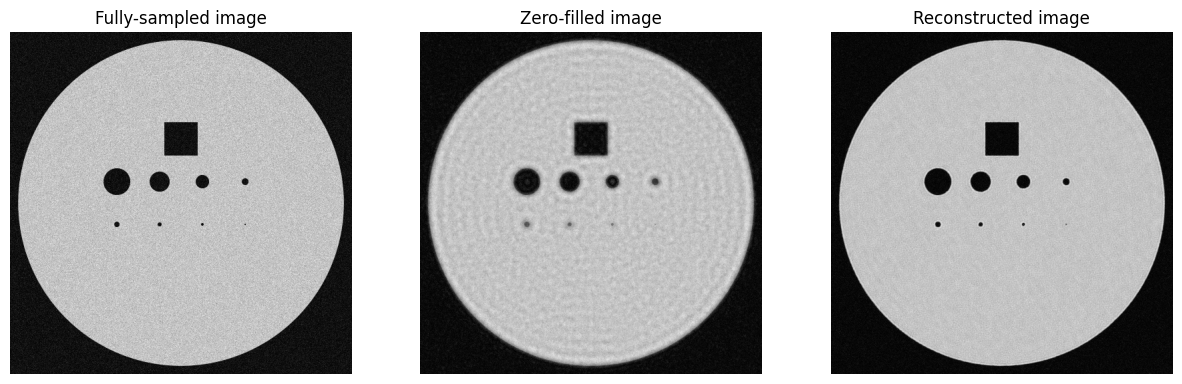

In [11]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.title('Fully-sampled image')
plt.imshow(abs(fs[0,0,:,:]), 'gray', vmax=abs(fs[0,0,:,:]).max())
plt.axis('off')

plt.subplot(132)
plt.title('Zero-filled image')
plt.imshow(abs(zf[0,0,:,:]), 'gray', vmax=abs(fs[0,0,:,:]).max())
plt.axis('off')

plt.subplot(133)
plt.title('Reconstructed image')
plt.imshow(abs(rec[0,0,:,:]), 'gray', vmax=abs(fs[0,0,:,:]).max())
plt.axis('off')

plt.show()